In [1]:
import time
import numpy as np
import pdb
import os
import sys
import seaborn as sns
import tensorflow

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from tensorflow.keras.layers import BatchNormalization

from tqdm import tqdm_notebook as tqdm

%matplotlib notebook
sns.set_style("dark")


%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

class Gaussian:
    def __init__(self, mu=None, sigma=None) -> None:
        '2D Gaussian pdf'
        D = 2
        self.mu = mu if mu is not None else  10 * (np.random.random(D) - 0.5)
        self.sigma = sigma if sigma is not None else 0.05*(np.eye(2) + 0.1*np.random.random((2,2)))
        self.sigma = (self.sigma + self.sigma.T)/2   # to make it symmetric
        self.sigmainv = np.linalg.inv(self.sigma)
        self.Z = 2*np.pi*np.sqrt(np.linalg.det(self.sigma))
    def sample(self, S=1):
        'return SxD np array'
        return np.random.multivariate_normal(self.mu, self.sigma, size=S)
    def prob(self, x_s):
        'x_s is SxD; returns an np array of len S'
        retval = []
        for x_mu in (x_s-self.mu):
             retval.append(np.exp(-0.5*(x_mu).T.dot(self.sigmainv).dot(x_mu))/self.Z)
        return np.array(retval)
        
class GMM:
    def __init__(self, N=5) -> None:
        'GMM with N Gaussian components'
        self.components = [Gaussian() for _ in range(N)] 
        self.weights = np.random.random(N)
        self.weights /= np.sum(self.weights)
    def sample(self, S=1):
        print(self.weights)
        retval = []
        count_z = np.random.multinomial(S, self.weights)
        print(count_z)
        for z, count in enumerate(count_z):
            retval.append(self.components[z].sample(S=count))
        return np.vstack(retval)
    def prob(self, x_s):
        retval = []
        p = np.zeros(len(x_s))
        for z, w in enumerate(self.weights):
            p += w * self.components[z].prob(x_s)
        return p

def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [3]:
# target 1D gaussian distribution class
class GaussianDistribution1:
    def __init__(self, mu=10 * (np.random.random(2) - 0.5), sigma=(5*np.eye(2) + 0.1*np.random.random((2,2))) ):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, N):
        samples = np.random.multivariate_normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

class Uniform:
    def __init__(self, a=-6, b=6 ):
        self.a = a
        self.b = b
    
    def sample(self, N):
        samples = np.array([np.random.uniform(self.a, self.b, N), np.random.uniform(self.a, self.b, N)]).T
        samples.sort()
        return samples

# generator input noise distribution class
class GeneratorNoiseDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma= sigma
        
    def sample(self, N):
        return np.random.normal(self.mu, self.sigma, N)

def generator(input_dim, hidden_size):
    g = Sequential()
    g.add(Dense(hidden_size, input_dim=input_dim, activation=K.softplus))
    g.add(Reshape((hidden_size, 1)))
    g.add(tensorflow.keras.layers.Conv1D(32, 3, padding='same', activation='relu',input_shape=(hidden_size, 1)))
    g.add(Flatten())
    g.add(Dense(2))
    return g

def discriminator(input_dim, hidden_size):
    d = Sequential()
    d.add(Dense(hidden_size*2, input_dim=input_dim, activation=K.tanh))
    d.add(Dense(hidden_size*2, activation=K.tanh))
    d.add(Dense(1, activation=K.sigmoid))
    return d

In [4]:
# init distributions
gaussian_d = GMM()
generator_d = Uniform(-6, 6)

# init GAN components
d = discriminator(2, 64)
g = generator(2, 64)

# discriminator model
optimizer = optimizers.RMSprop(learning_rate=0.0008, clipvalue=200.0, decay=6e-8)
discriminator_model = d
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse', 'mae', 'mape', 'cosine'])

# adversarial model
optimizer = optimizers.RMSprop(learning_rate=0.0004, clipvalue=200.0, decay=3e-8)
adversarial_model = Sequential()
adversarial_model.add(g)
adversarial_model.add(d)
adversarial_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse', 'mae', 'mape', 'cosine'])

[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 203 303 387 106]
(1000, 2)


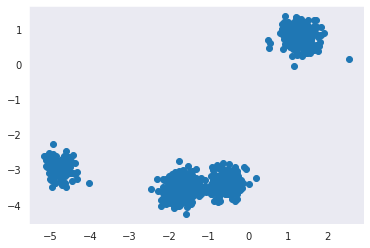

In [5]:
true_dist = np.reshape(gaussian_d.sample(1000), (1000, 2))
print(true_dist.shape)
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(true_dist[:,0], true_dist[:,1])
plt.show()

[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 219 286 399  96]
(1000, 2)
0
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 244 269 417  94]
0
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 217 260 425 121]
1
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 230 261 422 110]
2
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 207 281 427 109]
3
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 234 269 409 111]
4
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 215 275 426 108]
5
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 226 278 421  98]
6
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  2 229 262 429 102]
7
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 199 281 436 108]
8
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  0 224 255 430 115]
9
[0.00068377 0.21463431 0.26640018 0.41039777 0.10788397]
[  1 225 278 417 103]
10
[0.00068377 0.214

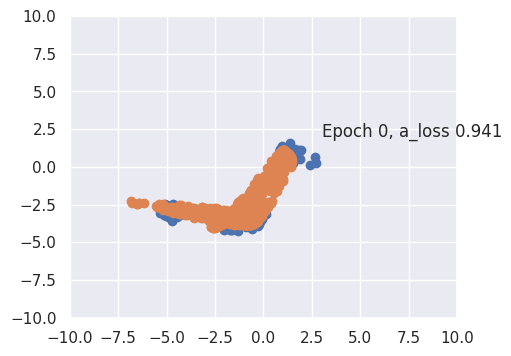

In [6]:
import warnings
warnings.filterwarnings('ignore')

batch_size = 1024
sns.set()
fig, ax = plt.subplots(dpi=100, figsize=(5, 4))
true_dist = np.reshape(gaussian_d.sample(1000), (1000, 2))
print(true_dist.shape)

def animate(step):
      print(step)
      # generate data
      # first we sample from the true distribution, then we generate some
      # "fake" data by feeding noise to the generator
      true_sample = np.reshape(gaussian_d.sample(batch_size), (batch_size, 2))
      noise = generator_d.sample(batch_size)
      fake_sample = g.predict(noise)
      
      # train discriminator
      # feed true and fake samples with respective labels (1, 0) to the discriminator
      x = np.reshape(np.concatenate((true_sample, fake_sample)), (batch_size*2, 2))
      y = np.ones([batch_size*2, 1])
      y[batch_size:, :] = 0
      d_loss = discriminator_model.train_on_batch(x, y)
      
      # train GAN
      # feed noise to the model and expect true (1) response from discriminator,
      # which is in turn fed with data generated by the generator
      noise = np.reshape(generator_d.sample(batch_size), (batch_size, 2))
      y = np.ones([batch_size, 1])
      a_loss = adversarial_model.train_on_batch(noise, y)
      
      log_mesg = "%d: [D loss: %f, acc: %f]" % (step, d_loss[0], d_loss[1])
      # print(log_mesg)
      log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
      # print(log_mesg)

      # plot
      fig.clf()
      plt.scatter(true_sample[:,0], true_sample[:,1])
      plt.scatter(fake_sample[:,0], fake_sample[:,1])
      plt.xlim([-10,10])
      plt.ylim([-10,10])
      plt.text(3, 2, "Epoch {}, a_loss {:.3f}".format(step, a_loss[0]))

anim = animation.FuncAnimation(fig, animate, frames=1000, interval = 20)
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

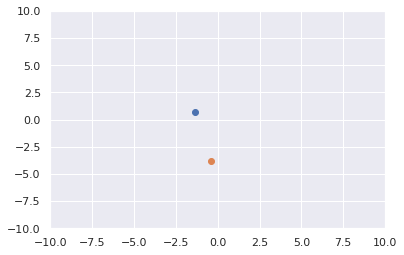

In [27]:
batch_size=1
noise = generator_d.sample(batch_size)
fake_sample = g.predict(noise)
plt.scatter(noise[:,0], noise[:,1])
plt.scatter(fake_sample[:,0], fake_sample[:,1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

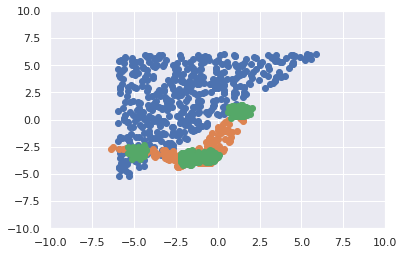

In [10]:
batch_size=500
noise = generator_d.sample(batch_size)
fake_sample = g.predict(noise)
plt.scatter(noise[:,0], noise[:,1])
plt.scatter(fake_sample[:,0], fake_sample[:,1])
plt.scatter(true_dist[:,0], true_dist[:,1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()